In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

data_dir = "./data"

device = torch.device("cpu")

if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")

if torch.cuda.is_available():
    device = torch.device("cuda")

print(f"Data resides in        : {data_dir}")
print(f"Training model on      : {str(device)}")

Data resides in        : ./data
Training model on      : mps


Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



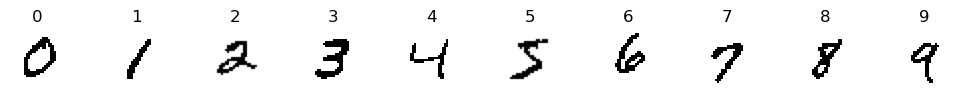

In [4]:
def print_samples(samples, elements_per_row=10, fig_width=10, cmap="binary"):
    num_digits = len(samples)
    num_rows = (num_digits + elements_per_row - 1) // elements_per_row

    plt.figure(figsize=(fig_width, fig_width / elements_per_row * num_rows))
    for idx, (label, image) in enumerate(samples):
        plt.subplot(num_rows, elements_per_row, idx + 1)
        plt.imshow(image.squeeze(), cmap=cmap)
        plt.title(label, fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# load MNIST and convert it to binary directly in transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,)),               # normalize to [0, 1]
    transforms.Lambda(lambda x: (x > 0.5).float())  # binarize
])

train_dataset = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)

sample_list = [(label, next(image for image, lbl in train_dataset if lbl == label)) for label in range(10)]
print_samples(sample_list)

In [5]:
class RBM(nn.Module):
    def __init__(self, visible_dim, hidden_dim=128, W_var=0.01, a_val=0.0, b_val=0.0):
        super().__init__()
        self.W = nn.Parameter(torch.randn(visible_dim, hidden_dim) * W_var)
        self.a = nn.Parameter(torch.full((visible_dim,), a_val))
        self.b = nn.Parameter(torch.full((hidden_dim,), b_val))

    def sample_hidden(self, v):
        h_probs = torch.sigmoid(v @ self.W + self.b)
        h_sample = torch.bernoulli(h_probs)
        return h_probs, h_sample

    def sample_visible(self, h):
        v_probs = torch.sigmoid(h @ self.W.t() + self.a)
        v_sample = torch.bernoulli(v_probs)
        return v_probs, v_sample

    def sample_gibbs(self, v0_sample, k=1):
        # we need to be careful not to run out of synch

        vk_probs, vk_sample = v0_sample.clone(), torch.zeros(v0_sample.size())
        hk_probs, hk_sample = self.sample_hidden(v0_sample)

        for _ in range(k):
            vk_probs, vk_sample = self.sample_visible(hk_sample)
            hk_probs, hk_sample = self.sample_hidden(vk_sample)

        return hk_probs, hk_sample, vk_probs, vk_sample

    def contrastive_divergence(self, v0_sample, k=1, lr=0.01):
        # positive phase
        h0_probs, h0_sample = self.sample_hidden(v0_sample)

        # negative phase
        hk_probs, _, vk_probs, vk_sample = self.sample_gibbs(v0_sample, k)

        # calculate associations (batch_dim vanishes during matrix multiplication)
        batch_size = v0_sample.size(0)
        positive_association = (v0_sample.T @ h0_probs) / batch_size
        negative_association = (vk_sample.T @ hk_probs) / batch_size

        # parameter step
        self.W.data += lr * (positive_association - negative_association)
        self.a.data += lr * (v0_sample.mean(dim=0) - vk_sample.mean(dim=0))
        self.b.data += lr * (h0_probs.mean(dim=0) - hk_probs.mean(dim=0))

        return vk_sample

In [6]:
hidden_dim = 2048
batch_size = 256
epochs = 100
lr = 0.01
gibbs_steps = 1


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


visible_dim = train_dataset[0][0].numel()
rbm = RBM(visible_dim, hidden_dim).to(device)


metrics = {}
for epoch in range(epochs):
    epoch_loss = 0.0
    for batch, _ in train_loader:
        flat_batch = batch.view(-1, visible_dim).to(device)

        recon_batch = rbm.contrastive_divergence(flat_batch, k=gibbs_steps)

        loss = torch.mean(torch.sum((flat_batch - recon_batch) ** 2, dim=1))
        epoch_loss += loss.item()

    metrics[epoch] = { "reconstruction_error": epoch_loss / len(train_loader) }
    print(f"Epoch {epoch + 1}/{epochs} : Loss {metrics[epoch]['reconstruction_error']:.4f}")

Epoch 1/100 : Loss 129.3247
Epoch 2/100 : Loss 100.9223
Epoch 3/100 : Loss 86.2644
Epoch 4/100 : Loss 78.2599
Epoch 5/100 : Loss 72.3728
Epoch 6/100 : Loss 67.7742
Epoch 7/100 : Loss 64.0785
Epoch 8/100 : Loss 61.0281
Epoch 9/100 : Loss 58.4653
Epoch 10/100 : Loss 56.1948
Epoch 11/100 : Loss 54.2266
Epoch 12/100 : Loss 52.5033
Epoch 13/100 : Loss 50.9739
Epoch 14/100 : Loss 49.5040
Epoch 15/100 : Loss 48.3059
Epoch 16/100 : Loss 47.1835
Epoch 17/100 : Loss 46.0883
Epoch 18/100 : Loss 45.1670
Epoch 19/100 : Loss 44.2502
Epoch 20/100 : Loss 43.4085
Epoch 21/100 : Loss 42.6929
Epoch 22/100 : Loss 42.0086
Epoch 23/100 : Loss 41.2979
Epoch 24/100 : Loss 40.6840
Epoch 25/100 : Loss 40.0919
Epoch 26/100 : Loss 39.4935
Epoch 27/100 : Loss 38.9671
Epoch 28/100 : Loss 38.4472
Epoch 29/100 : Loss 37.9566
Epoch 30/100 : Loss 37.5063
Epoch 31/100 : Loss 37.0925
Epoch 32/100 : Loss 36.6717
Epoch 33/100 : Loss 36.2634
Epoch 34/100 : Loss 35.8710
Epoch 35/100 : Loss 35.5432
Epoch 36/100 : Loss 35.1930

Text(0, 0.5, 'Reconstruction Error')

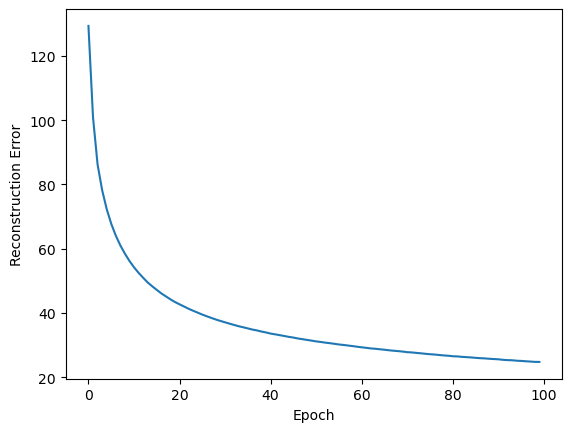

In [7]:
# only plot the reconstruction_error
plt.plot([metrics[epoch]['reconstruction_error'] for epoch in metrics])
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error")

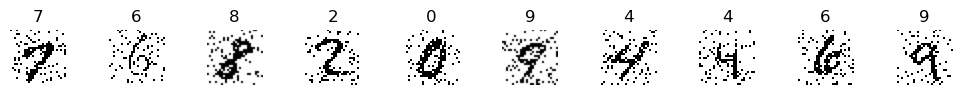

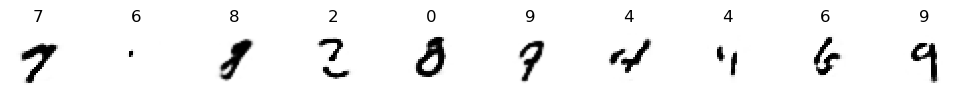

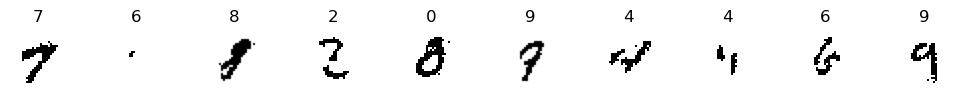

In [8]:
# getting some random samples with noise
random_labels = torch.randint(0, 10, (10,))
noise_level = 0.1

demo_samples = []
label_idx = 0

for image, lbl in train_dataset:
    if label_idx >= len(random_labels):
        break

    if lbl == random_labels[label_idx]:
        demo_samples.append((lbl, image))

        noise = torch.rand_like(image)
        image[noise < noise_level] = 1 - image[noise < noise_level]

        label_idx += 1


# performing reconstruction
demo_recon_probs = []
demo_recon_samples = []
with torch.no_grad():
    for digit, sample in demo_samples:
        flat_sample = sample.view(-1, visible_dim).to(device)

        _, _, v_probs, v_sample = rbm.sample_gibbs(flat_sample, k=10)

        demo_recon_probs.append((digit, v_probs.view(28, 28).cpu()))
        demo_recon_samples.append((digit, v_sample.view(28, 28).cpu()))


inverted_demo_recon_probs = [(digit, 1 - v_prob) for digit, v_prob in demo_recon_probs]

print_samples(demo_samples, elements_per_row=10, cmap="binary")
print_samples(inverted_demo_recon_probs, elements_per_row=10, cmap="gray")
print_samples(demo_recon_samples, elements_per_row=10, cmap="binary")

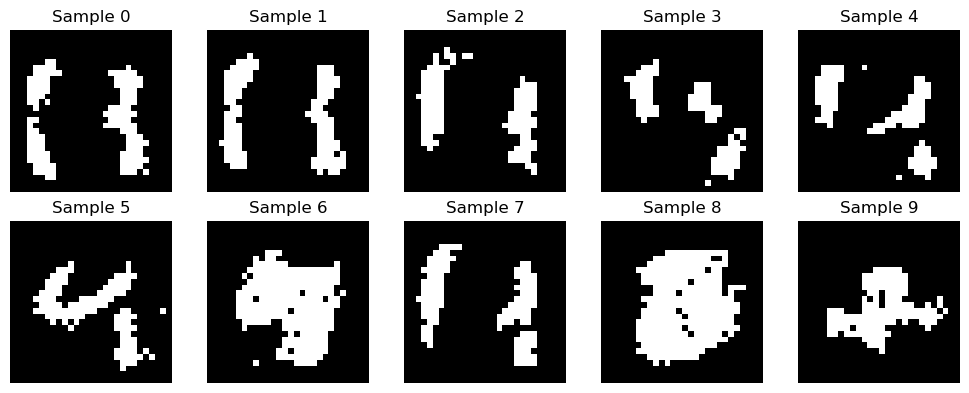

In [9]:
# generation starting from random noise
generation_steps = 30

with torch.no_grad():
    random_samples = torch.bernoulli(torch.rand(10, visible_dim)).to(device)
    _, _, _, random_recon = rbm.sample_gibbs(random_samples, k=generation_steps)

    random_recon = random_recon.view(-1, 28, 28).cpu()

print_samples([(f"Sample {idx}", sample) for idx, sample in enumerate(random_recon)], elements_per_row=5, cmap="gray")